In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-08 02:44:11.981098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 02:44:11.989640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 02:44:11.989975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-08 02:44:12.250157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 02:44:12.250927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 02:44:12.251259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 02:44:12.251540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.04431772e+00, 3.59836370e-01, 0.00000000e+00],
         [0.00000000e+00, 8.93106282e-01, 0.00000000e+00],
         ...,
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.82914233e+00, 4.03478479e+00, 0.00000000e+00],
         [6.72403991e-01, 0.00000000e+00, 8.05169642e-02],
         ...,
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
         [7.26516037e+01, 7.63300095e+01, 7.92575150e+01]],

        [[0.00000000e+00, 0.00000000e+00, 2.36478090e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.11826062e+00, 7.04266354e-02],
         ...,
         [2

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [1.04431772e+00, 3.59836370e-01, 0.00000000e+00],
          [0.00000000e+00, 8.93106282e-01, 0.00000000e+00],
          ...,
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [1.82914233e+00, 4.03478479e+00, 0.00000000e+00],
          [6.72403991e-01, 0.00000000e+00, 8.05169642e-02],
          ...,
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [7.26516037e+01, 7.63300095e+01, 7.92575150e+01]],
 
         [[0.00000000e+00, 0.00000000e+00, 2.36478090e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 3.11826062e+00, 7.04266354e-0

<IPython.core.display.Javascript object>


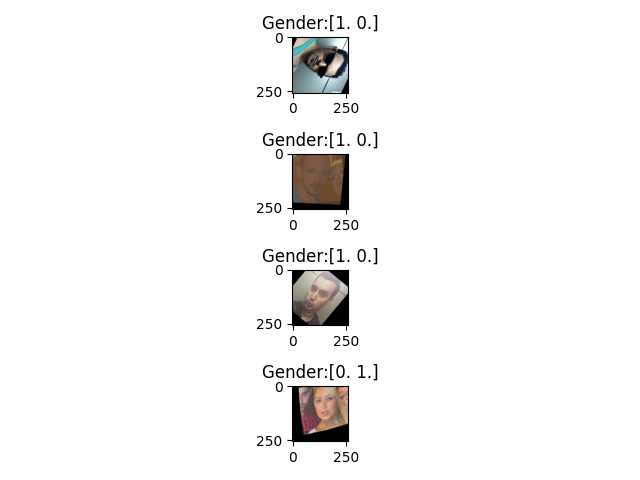

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, 7, strides=(4,4), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 5, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(32, 1, padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(256, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_22')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 256

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 256)          2677792     ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_22"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-08 02:44:15.699296: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-08 02:44:15.699313: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-08 02:44:15.699332: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-08 02:44:15.776142: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-08 02:44:15.777755: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-08 02:44:16.399351: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  13/3528 [..............................] - ETA: 15s - loss: 7142.3247 - gender_out_loss: 0.6908 - tf.math.multiply_1_loss: 5415.3311 - gender_out_accuracy: 0.5385        

2022-11-08 02:44:17.119055: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7726.7656 - gender_out_loss: 0.6944 - tf.math.multiply_1_loss: 5990.7153 - gender_out_accuracy: 0.4708
Epoch 1/300
   1/1000 [..............................] - ETA: 14:57 - loss: 7925.2358 - gender_out_loss: 0.6816 - tf.math.multiply_1_loss: 6221.2324 - gender_out_accuracy: 0.7500

2022-11-08 02:44:31.340357: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-08 02:44:31.340557: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:05 - loss: 9299.4551 - gender_out_loss: 0.7340 - tf.math.multiply_1_loss: 7464.5298 - gender_out_accuracy: 0.5000

2022-11-08 02:44:31.764278: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-08 02:44:31.765137: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-08 02:44:31.795865: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2891 callback api events and 2850 activity events. 
2022-11-08 02:44:31.819603: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-08 02:44:31.849335: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_22/log_0/plugins/profile/2022_11_08_02_44_31

2022-11-08 02:44:31.889867: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_22/log_0/plugins/profile/2022_11_08_02_44_31/rachanon-pc1.trace.json.gz
2022-11-08 02:44:31.925180: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 22s 21ms/step - loss: 4332.3677 - gender_out_loss: 0.6784 - tf.math.multiply_1_loss: 2636.3064 - gender_out_accuracy: 0.5872 - val_loss: 3587.3440 - val_gender_out_loss: 0.6821 - val_tf.math.multiply_1_loss: 1881.9879 - val_gender_out_accuracy: 0.5535
Epoch 2/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3060.5400 - gender_out_loss: 0.6522 - tf.math.multiply_1_loss: 1430.0858 - gender_out_accuracy: 0.6273 - val_loss: 3235.2522 - val_gender_out_loss: 0.6800 - val_tf.math.multiply_1_loss: 1535.2617 - val_gender_out_accuracy: 0.5682
Epoch 3/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2826.7434 - gender_out_loss: 0.6504 - tf.math.multiply_1_loss: 1200.8198 - gender_out_accuracy: 0.6080 - val_loss: 3005.8032 - val_gender_out_loss: 0.6861 - val_tf.math.multiply_1_loss: 1290.6028 - val_gender_out_accuracy: 0.5632
Epoch 4/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2728.3

Epoch 28/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2257.9292 - gender_out_loss: 0.6502 - tf.math.multiply_1_loss: 632.3764 - gender_out_accuracy: 0.6133 - val_loss: 2547.1360 - val_gender_out_loss: 0.7030 - val_tf.math.multiply_1_loss: 789.6671 - val_gender_out_accuracy: 0.5633
Epoch 29/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2204.9775 - gender_out_loss: 0.6375 - tf.math.multiply_1_loss: 611.1514 - gender_out_accuracy: 0.6455 - val_loss: 2398.3591 - val_gender_out_loss: 0.6595 - val_tf.math.multiply_1_loss: 749.5359 - val_gender_out_accuracy: 0.6002
Epoch 30/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2182.1685 - gender_out_loss: 0.6250 - tf.math.multiply_1_loss: 619.7424 - gender_out_accuracy: 0.6497 - val_loss: 2537.5149 - val_gender_out_loss: 0.7205 - val_tf.math.multiply_1_loss: 736.3223 - val_gender_out_accuracy: 0.5527
Epoch 31/300
1000/1000 [==============================] - 21s 21ms/step - lo

Epoch 55/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2066.0881 - gender_out_loss: 0.6220 - tf.math.multiply_1_loss: 511.0813 - gender_out_accuracy: 0.6600 - val_loss: 2248.9167 - val_gender_out_loss: 0.6525 - val_tf.math.multiply_1_loss: 617.6437 - val_gender_out_accuracy: 0.6144
Epoch 56/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2042.2408 - gender_out_loss: 0.6106 - tf.math.multiply_1_loss: 515.6938 - gender_out_accuracy: 0.6610 - val_loss: 2235.0791 - val_gender_out_loss: 0.6501 - val_tf.math.multiply_1_loss: 609.8446 - val_gender_out_accuracy: 0.6070
Epoch 57/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2057.3779 - gender_out_loss: 0.6192 - tf.math.multiply_1_loss: 509.3246 - gender_out_accuracy: 0.6532 - val_loss: 2258.2363 - val_gender_out_loss: 0.6619 - val_tf.math.multiply_1_loss: 603.4325 - val_gender_out_accuracy: 0.5959
Epoch 58/300
1000/1000 [==============================] - 20s 21ms/step - lo

Epoch 82/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2006.8610 - gender_out_loss: 0.6134 - tf.math.multiply_1_loss: 473.4060 - gender_out_accuracy: 0.6637 - val_loss: 2140.8560 - val_gender_out_loss: 0.6275 - val_tf.math.multiply_1_loss: 571.9902 - val_gender_out_accuracy: 0.6610
Epoch 83/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1921.0614 - gender_out_loss: 0.5713 - tf.math.multiply_1_loss: 492.7185 - gender_out_accuracy: 0.7030 - val_loss: 2251.6243 - val_gender_out_loss: 0.6740 - val_tf.math.multiply_1_loss: 566.7173 - val_gender_out_accuracy: 0.5834
Epoch 84/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1955.9154 - gender_out_loss: 0.5913 - tf.math.multiply_1_loss: 477.6559 - gender_out_accuracy: 0.6755 - val_loss: 2361.9631 - val_gender_out_loss: 0.7126 - val_tf.math.multiply_1_loss: 580.4712 - val_gender_out_accuracy: 0.5828
Epoch 85/300
1000/1000 [==============================] - 21s 21ms/step - lo

Epoch 109/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1892.4421 - gender_out_loss: 0.5700 - tf.math.multiply_1_loss: 467.3649 - gender_out_accuracy: 0.7038 - val_loss: 2075.7246 - val_gender_out_loss: 0.6124 - val_tf.math.multiply_1_loss: 544.6984 - val_gender_out_accuracy: 0.6678
Epoch 110/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1943.3184 - gender_out_loss: 0.5949 - tf.math.multiply_1_loss: 456.0093 - gender_out_accuracy: 0.6927 - val_loss: 2051.6082 - val_gender_out_loss: 0.6006 - val_tf.math.multiply_1_loss: 550.0362 - val_gender_out_accuracy: 0.6665
Epoch 111/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1869.1891 - gender_out_loss: 0.5621 - tf.math.multiply_1_loss: 463.9992 - gender_out_accuracy: 0.7010 - val_loss: 2123.4678 - val_gender_out_loss: 0.6304 - val_tf.math.multiply_1_loss: 547.3878 - val_gender_out_accuracy: 0.6426
Epoch 112/300
1000/1000 [==============================] - 21s 21ms/step 

1000/1000 [==============================] - 21s 21ms/step - loss: 1876.1078 - gender_out_loss: 0.5735 - tf.math.multiply_1_loss: 442.3668 - gender_out_accuracy: 0.6965 - val_loss: 1955.1373 - val_gender_out_loss: 0.5720 - val_tf.math.multiply_1_loss: 525.1748 - val_gender_out_accuracy: 0.7031
Epoch 136/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1808.4711 - gender_out_loss: 0.5370 - tf.math.multiply_1_loss: 465.9099 - gender_out_accuracy: 0.7297 - val_loss: 1992.5498 - val_gender_out_loss: 0.5843 - val_tf.math.multiply_1_loss: 531.8380 - val_gender_out_accuracy: 0.6977
Epoch 137/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1864.1982 - gender_out_loss: 0.5686 - tf.math.multiply_1_loss: 442.7574 - gender_out_accuracy: 0.6955 - val_loss: 2022.3715 - val_gender_out_loss: 0.5877 - val_tf.math.multiply_1_loss: 553.0380 - val_gender_out_accuracy: 0.6834
Epoch 138/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1916.2

1000/1000 [==============================] - 21s 21ms/step - loss: 1831.6622 - gender_out_loss: 0.5594 - tf.math.multiply_1_loss: 433.2150 - gender_out_accuracy: 0.7107 - val_loss: 2440.4922 - val_gender_out_loss: 0.7681 - val_tf.math.multiply_1_loss: 520.2269 - val_gender_out_accuracy: 0.6233
Epoch 162/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1854.0597 - gender_out_loss: 0.5611 - tf.math.multiply_1_loss: 451.2690 - gender_out_accuracy: 0.7157 - val_loss: 2111.8796 - val_gender_out_loss: 0.6379 - val_tf.math.multiply_1_loss: 517.1693 - val_gender_out_accuracy: 0.6546
Epoch 163/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1815.2924 - gender_out_loss: 0.5529 - tf.math.multiply_1_loss: 433.0226 - gender_out_accuracy: 0.7250 - val_loss: 1900.4152 - val_gender_out_loss: 0.5501 - val_tf.math.multiply_1_loss: 525.1790 - val_gender_out_accuracy: 0.7175
Epoch 164/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1760.3

1000/1000 [==============================] - 21s 21ms/step - loss: 1873.7031 - gender_out_loss: 0.5758 - tf.math.multiply_1_loss: 434.0960 - gender_out_accuracy: 0.6935 - val_loss: 2219.4980 - val_gender_out_loss: 0.6784 - val_tf.math.multiply_1_loss: 523.3932 - val_gender_out_accuracy: 0.6457
Epoch 188/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1734.0168 - gender_out_loss: 0.5229 - tf.math.multiply_1_loss: 426.6494 - gender_out_accuracy: 0.7412 - val_loss: 2114.4050 - val_gender_out_loss: 0.6369 - val_tf.math.multiply_1_loss: 522.0718 - val_gender_out_accuracy: 0.6984
Epoch 189/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1748.7412 - gender_out_loss: 0.5262 - tf.math.multiply_1_loss: 433.3443 - gender_out_accuracy: 0.7347 - val_loss: 1873.8136 - val_gender_out_loss: 0.5441 - val_tf.math.multiply_1_loss: 513.4973 - val_gender_out_accuracy: 0.7240
Epoch 190/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1786.7

1000/1000 [==============================] - 21s 21ms/step - loss: 1648.1292 - gender_out_loss: 0.4920 - tf.math.multiply_1_loss: 418.1387 - gender_out_accuracy: 0.7610 - val_loss: 1883.5219 - val_gender_out_loss: 0.5482 - val_tf.math.multiply_1_loss: 513.0782 - val_gender_out_accuracy: 0.7287
Epoch 214/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1726.0355 - gender_out_loss: 0.5275 - tf.math.multiply_1_loss: 407.3815 - gender_out_accuracy: 0.7370 - val_loss: 1964.4926 - val_gender_out_loss: 0.5834 - val_tf.math.multiply_1_loss: 506.1072 - val_gender_out_accuracy: 0.7026
Epoch 215/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1808.1863 - gender_out_loss: 0.5524 - tf.math.multiply_1_loss: 427.0694 - gender_out_accuracy: 0.7235 - val_loss: 2005.4948 - val_gender_out_loss: 0.6003 - val_tf.math.multiply_1_loss: 504.6237 - val_gender_out_accuracy: 0.6805
Epoch 216/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1723.0

1000/1000 [==============================] - 21s 21ms/step - loss: 1678.5663 - gender_out_loss: 0.5058 - tf.math.multiply_1_loss: 413.9475 - gender_out_accuracy: 0.7440 - val_loss: 1796.4689 - val_gender_out_loss: 0.5151 - val_tf.math.multiply_1_loss: 508.6179 - val_gender_out_accuracy: 0.7399
Epoch 240/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1741.1307 - gender_out_loss: 0.5246 - tf.math.multiply_1_loss: 429.7331 - gender_out_accuracy: 0.7402 - val_loss: 2130.7346 - val_gender_out_loss: 0.6421 - val_tf.math.multiply_1_loss: 525.5904 - val_gender_out_accuracy: 0.6944
Epoch 241/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1636.3865 - gender_out_loss: 0.4894 - tf.math.multiply_1_loss: 412.9868 - gender_out_accuracy: 0.7558 - val_loss: 2353.9280 - val_gender_out_loss: 0.7392 - val_tf.math.multiply_1_loss: 506.0140 - val_gender_out_accuracy: 0.6367
Epoch 242/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1718.4

1000/1000 [==============================] - 21s 21ms/step - loss: 1634.1061 - gender_out_loss: 0.4841 - tf.math.multiply_1_loss: 423.7399 - gender_out_accuracy: 0.7638 - val_loss: 1870.2145 - val_gender_out_loss: 0.5457 - val_tf.math.multiply_1_loss: 505.8878 - val_gender_out_accuracy: 0.7159
Epoch 266/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1584.4490 - gender_out_loss: 0.4739 - tf.math.multiply_1_loss: 399.7358 - gender_out_accuracy: 0.7710 - val_loss: 1756.7617 - val_gender_out_loss: 0.5042 - val_tf.math.multiply_1_loss: 496.2339 - val_gender_out_accuracy: 0.7591
Epoch 267/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1632.6171 - gender_out_loss: 0.4924 - tf.math.multiply_1_loss: 401.5900 - gender_out_accuracy: 0.7580 - val_loss: 1810.9181 - val_gender_out_loss: 0.5274 - val_tf.math.multiply_1_loss: 492.4526 - val_gender_out_accuracy: 0.7318
Epoch 268/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1731.3

1000/1000 [==============================] - 21s 21ms/step - loss: 1578.7800 - gender_out_loss: 0.4636 - tf.math.multiply_1_loss: 419.7323 - gender_out_accuracy: 0.7803 - val_loss: 1834.1431 - val_gender_out_loss: 0.5384 - val_tf.math.multiply_1_loss: 488.1536 - val_gender_out_accuracy: 0.7361
Epoch 292/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1655.2139 - gender_out_loss: 0.5005 - tf.math.multiply_1_loss: 403.8832 - gender_out_accuracy: 0.7492 - val_loss: 1760.8323 - val_gender_out_loss: 0.5007 - val_tf.math.multiply_1_loss: 509.0669 - val_gender_out_accuracy: 0.7593
Epoch 293/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1596.1576 - gender_out_loss: 0.4719 - tf.math.multiply_1_loss: 416.4299 - gender_out_accuracy: 0.7772 - val_loss: 1962.2352 - val_gender_out_loss: 0.5778 - val_tf.math.multiply_1_loss: 517.7226 - val_gender_out_accuracy: 0.7459
Epoch 294/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1571.9

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[4.60778475e-01, 3.50265205e-01, 3.21158767e-01],
          [1.30477399e-01, 7.37920403e-02, 5.13428450e-02],
          [7.58819282e-02, 4.31124866e-02, 3.72987986e-02],
          ...,
          [1.86223663e+02, 1.91276001e+02, 1.87882370e+02],
          [1.68773361e+02, 1.80348999e+02, 1.80146301e+02],
          [1.52147125e+02, 1.60895035e+02, 1.59694031e+02]],
 
         [[6.78947568e-02, 5.75897098e-02, 4.79534268e-02],
          [1.44468248e-02, 1.07078254e-02, 9.03591514e-03],
          [4.49667871e-02, 2.36043334e-02, 2.10432708e-02],
          ...,
          [2.03444366e+02, 2.11965729e+02, 2.08842880e+02],
          [1.85573624e+02, 1.98259827e+02, 1.97861252e+02],
          [1.62937820e+02, 1.78960541e+02, 1.82760834e+02]],
 
         [[8.40894878e-02, 6.21038675e-02, 4.60763276e-02],
          [4.93745506e-02, 4.99977171e-02, 3.64400446e-02],
          [8.98423791e-02, 7.87165761e-02, 5.58722019e-0

<IPython.core.display.Javascript object>


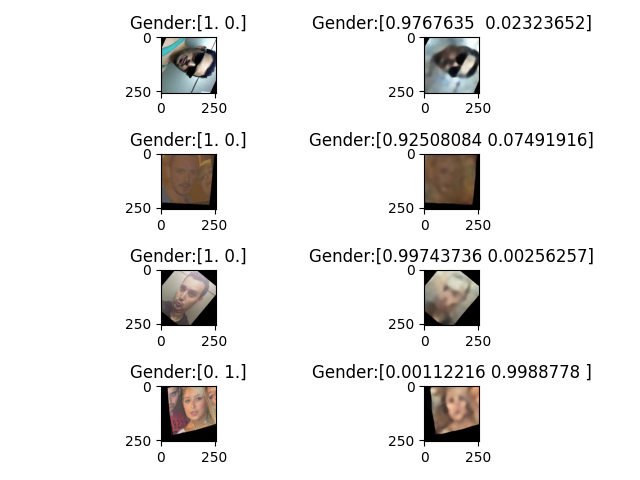

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[7.94385374e-02, 8.57385993e-02, 7.71890581e-02],
          [1.34588778e-02, 1.04950368e-02, 6.51285052e-03],
          [6.56604767e-03, 3.71620059e-03, 3.05503607e-03],
          ...,
          [1.93987954e+00, 1.46447182e+00, 1.62284732e+00],
          [2.03213096e+00, 1.35642838e+00, 1.31532216e+00],
          [2.49265099e+00, 2.03186488e+00, 1.35903502e+00]],
 
         [[9.49949026e-03, 8.45834613e-03, 8.00997019e-03],
          [7.37160444e-04, 6.61164522e-04, 4.63575125e-04],
          [3.03223729e-03, 1.26153231e-03, 1.15513802e-03],
          ...,
          [1.01461399e+00, 7.64678597e-01, 8.66475105e-01],
          [1.21582842e+00, 7.96216846e-01, 6.59842193e-01],
          [1.50096512e+00, 1.11863720e+00, 7.47374296e-01]],
 
         [[9.96306539e-03, 7.62999058e-03, 6.11007214e-03],
          [2.00629234e-03, 3.41221690e-03, 2.00629234e-03],
          [5.16012311e-03, 5.44130802e-03, 3.38941813e-0

<IPython.core.display.Javascript object>


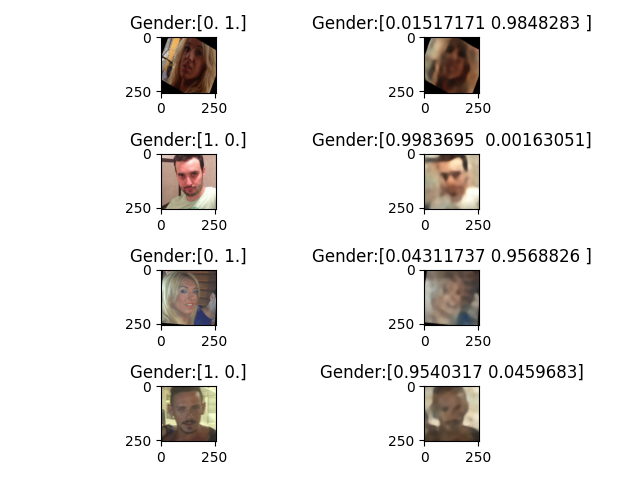

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()